#  Run BADASS on Alpha Amylase

In [ ]:
%run setup_environment.py
import seq2fitness_models as models
import seq2fitness_traintools as traintools
import seq2fitness_train as train
import seq2fitness_protein_optimizer as protein_optimizer
import pickle
import time
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Using ESM2 Only

In [ ]:
esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only

model_params = {
    'ref_seq': ref_seq_amylase, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}

optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter': 200, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': 35,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': 5,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

# Initialize optimizer
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_params=model_params, 
                                               esm_only=True,
                                               score_matrix=None, # Initialize in optimizer
                                               simple_simulated_annealing=False, 
                                               cool_then_heat=False)
print(f"phase transition threshold is {optimizer.score_threshold}")

In [4]:
# Run the optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 5.73e+03 effective entries: 331 sites, 18.4 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of -1.87, and std. dev. 9.16.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 4.72e+03 effective entries: 306 sites, 17.8 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of 0.307, and std. dev. 8.43.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 4.02e+03 effective entries: 286 sites, 17.3 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 2.91, and std. dev. 7.89.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 3.41

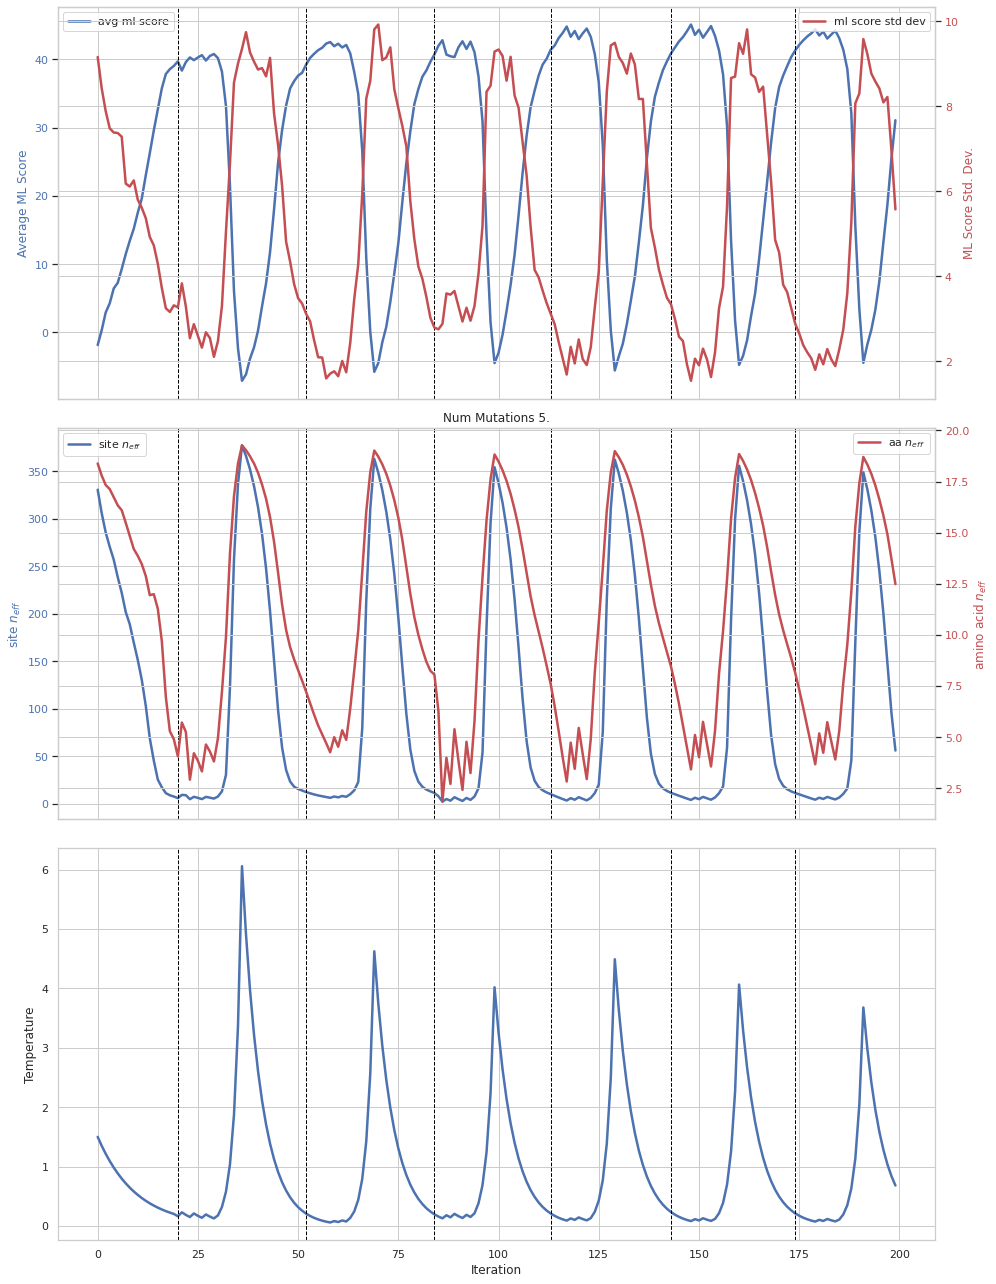

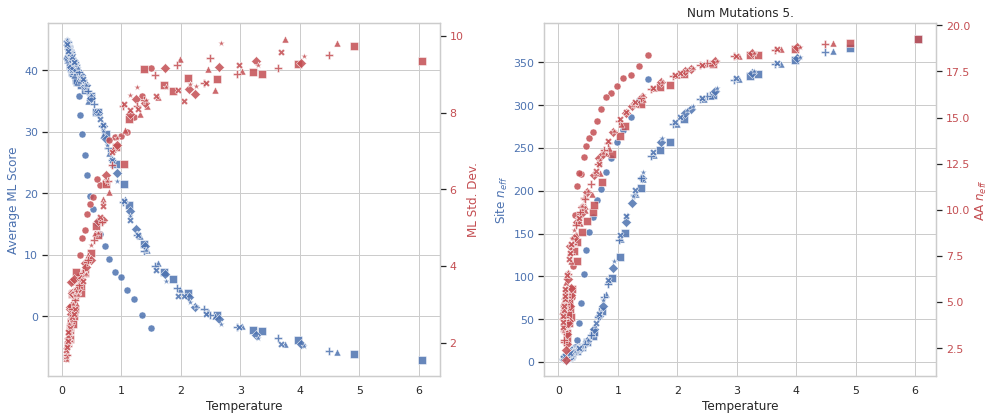

19
19


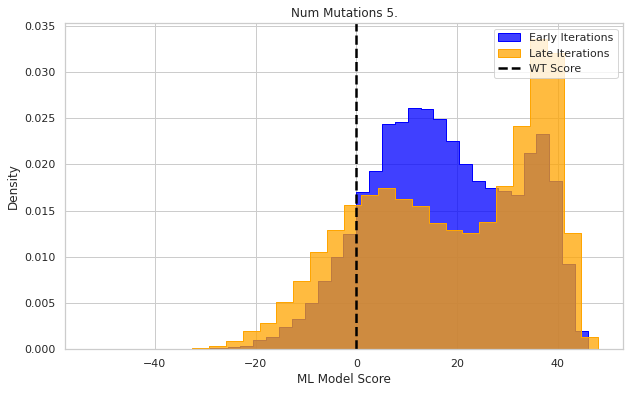

In [5]:
# View optimization history
optimizer.plot_scores()

In [7]:
# Save optimizer results
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
seed = optimizer_params['seed']
fn = f"protein_optimizer_results_num_mutations_{n_mut}_nsteps_{n_steps}_seed_{seed}_n_seqs_to_keep_{len(df)}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=None)

# View runtime
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
torch.cuda.empty_cache()
gc.collect()

Elapsed time: 883.09 seconds


14836

There were 65967 unique sequences found.
Best Sequence:
I117N-T121F-A328D-E331K-N364V
Best Score: 47.8984
Percentiles:
  25th Percentile: 4.7480
  50th Percentile: 19.7734
  75th Percentile: 34.5234
  90th Percentile: 39.1055
  99th Percentile: 43.4453


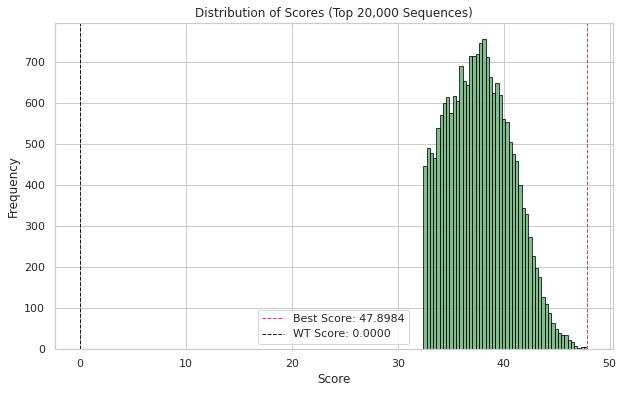

In [8]:

# Visualize scores of designed sequences

# Compute the percentiles
percentiles = np.percentile(df['ml_score'], [25, 50, 75, 90, 99])

# Find the best sequence and its score
best_score = df['ml_score'].max()
best_sequence = df.loc[df['ml_score'].idxmax(), 'sequences']

# Print the unique sequences found
print(f"There were {len(set(df['sequences']))} unique sequences found.")

# Print the best sequence and its score
print(f"Best Sequence:")
print(best_sequence)

print(f"Best Score: {best_score:.4f}")

# Print the percentiles
print(f"Percentiles:")
print(f"  25th Percentile: {percentiles[0]:.4f}")
print(f"  50th Percentile: {percentiles[1]:.4f}")
print(f"  75th Percentile: {percentiles[2]:.4f}")
print(f"  90th Percentile: {percentiles[3]:.4f}")
print(f"  99th Percentile: {percentiles[4]:.4f}")

# Plot the score distribution of the top 10,000 sequences
top_n = 20000
top_10000_df = df.nlargest(top_n, 'ml_score')

plt.figure(figsize=(10, 6))
plt.hist(top_10000_df['ml_score'], bins=50, alpha=0.75, color='g', edgecolor='black')
plt.axvline(best_score, color='r', linestyle='dashed', linewidth=1, label=f'Best Score: {best_score:.4f}')
plt.axvline(optimizer.wt_score, color='k', linestyle='dashed', linewidth=1, label=f'WT Score: {float(optimizer.wt_score):.4f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Scores (Top {top_n:,} Sequences)')
plt.legend()
plt.grid(True)
plt.savefig(f'Distribution of Scores (Top {top_n:,} Sequences)', bbox_inches='tight', dpi=200)
plt.show()

## Using Seq2Fitness model

In [9]:
# Initialize optimizer

model_path = '../trained_models/Seq2Fitness_AAmylsase_DEMLPaper__modelrank_1_epoch_45_val_loss_0.5990.pt'

new_task_weights = {'fitness_dp3_activity': 2.0, 'fitness_stain_removal': 1.0}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': 3.5,
    'reversal_threshold': 0.0,
    'seqs_per_iter': 520, # typically 1000
    'num_iter': 200, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, 
    'cooling_rate': 0.93, 
    'num_mutations': 5,
    'sample_variety_of_mutation_numbers': False,
    'sites_to_ignore': [1] # High tendency to mutate to Met, so avoid
}


optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path,
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=initial_score_matrix,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat=False)
print(f"phase transition threshold is {optimizer.score_threshold}")

Our main device will be cuda:0
Total number of trainable parameters in the model: 125470
Number of trainable parameters in the model excluding ESM: 125470
Total number of parameters in the model: 651168724
The reference sequence is LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTPIKNWSDRWDVTQNSLSGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSVSRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYAVDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPD.
Our main device is still cuda:0
The reference sequence has score 0.8.
Reference score value: 0.6102, std dev: 0.5228. To normalize scores.
phase transition threshold is 3.5


In [11]:
# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 7.03e+03 effective entries: 379 sites, 19.4 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 520 sequences. Finished iter 0 with mean ml score of -0.56, and std. dev. 0.331.
Starting iter 1: processing 520 sequences, using T = 1.4.
Joint probability has 6.97e+03 effective entries: 377 sites, 19.4 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 1040 sequences. Finished iter 1 with mean ml score of -0.567, and std. dev. 0.333.
Starting iter 2: processing 520 sequences, using T = 1.3.
Joint probability has 6.92e+03 effective entries: 375 sites, 19.4 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 1560 sequences. Finished iter 2 with mean ml score of -0.552, and std. dev. 0.357.
Starting iter 3: processing 520 sequences, using T = 1.2.
Joint probability ha

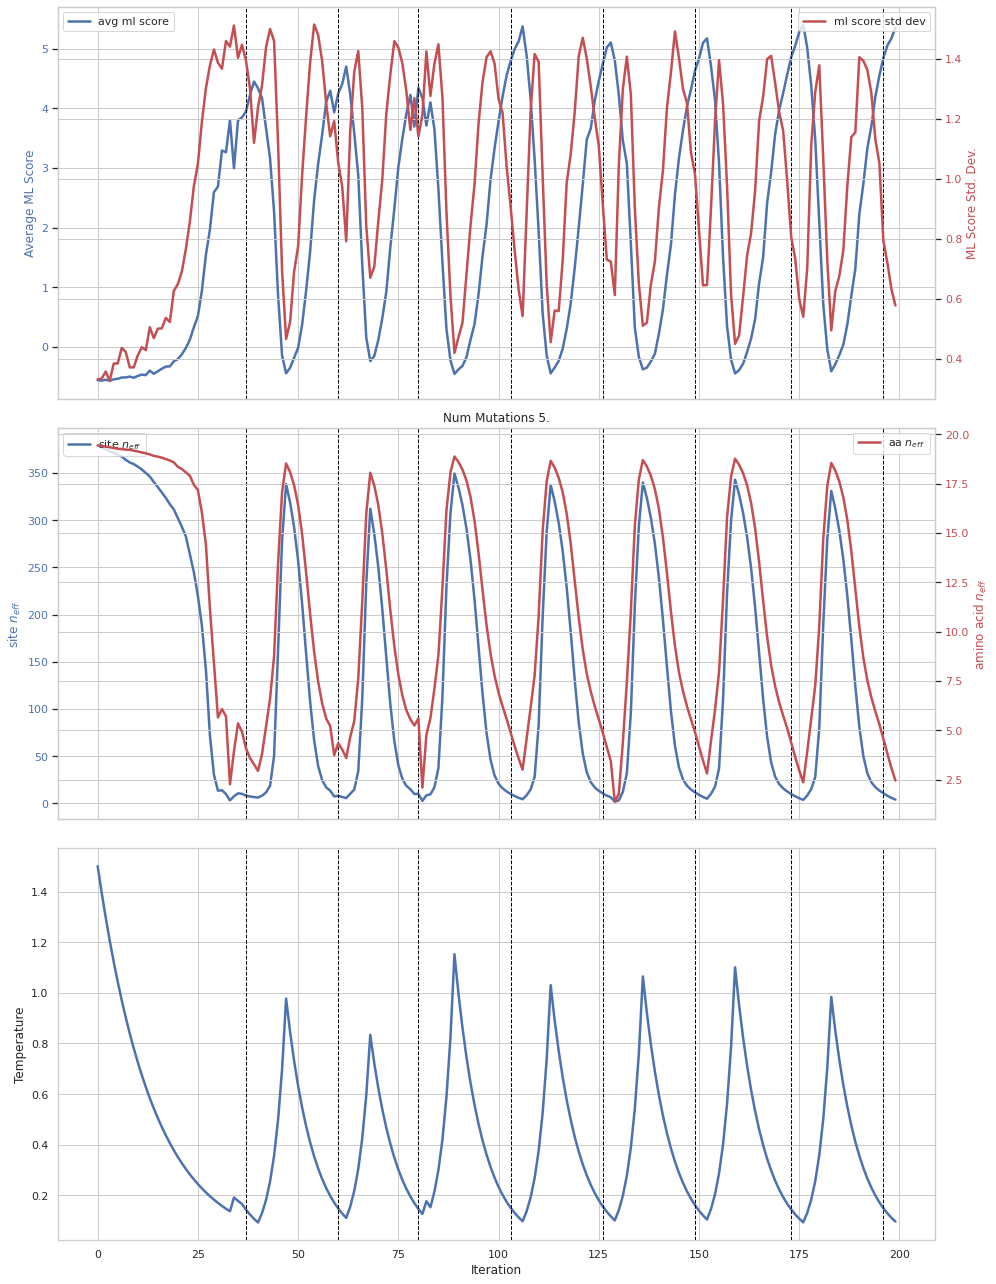

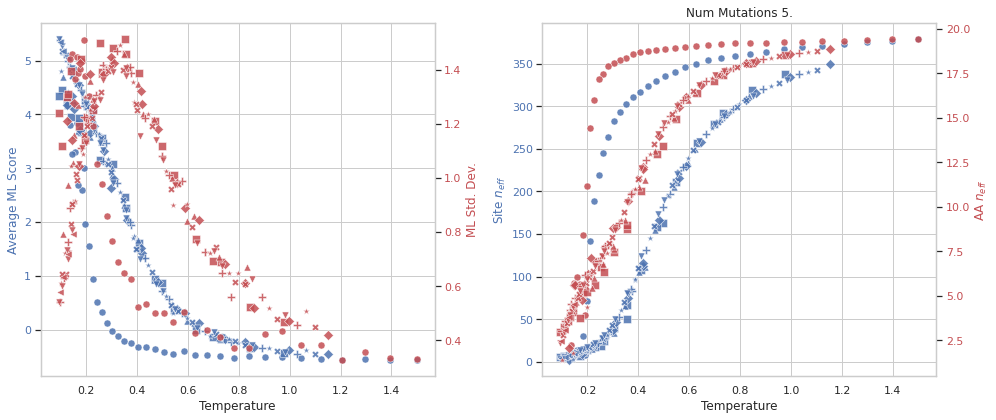

36
36


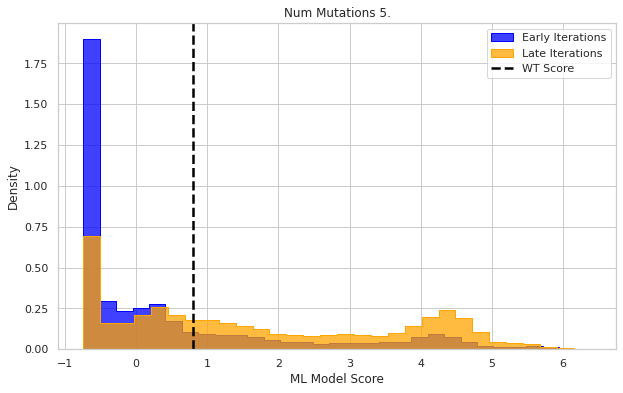

In [12]:
# Visualize optimizer history
optimizer.plot_scores()

In [13]:
# Save optimizer results
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
seed = optimizer_params['seed']
fn = f"protein_optimizer_results_num_mutations_{n_mut}_nsteps_{n_steps}_seed_{seed}_n_seqs_to_keep_{len(df)}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=None)

In [14]:
# Print duration
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
torch.cuda.empty_cache()
gc.collect()

Elapsed time: 1187.40 seconds


13769

There were 84691 unique sequences found.
Best Sequence:
T2L-P4Q-A108W-T125L-V292I
Best Score: 6.3890
Percentiles:
  25th Percentile: -0.3764
  50th Percentile: 0.8466
  75th Percentile: 3.2394
  90th Percentile: 4.4217
  99th Percentile: 5.4922


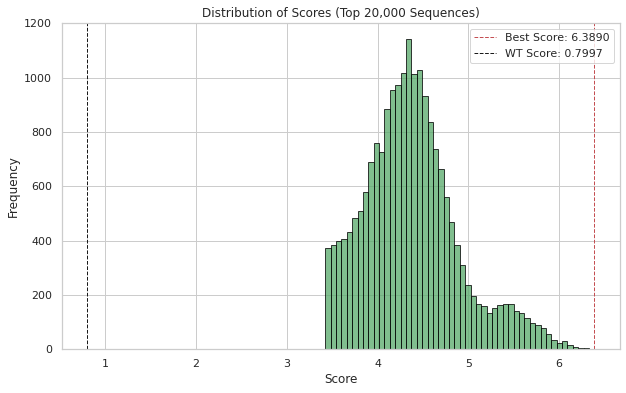

In [15]:
# Assuming df is already loaded with the given structure

# Compute the percentiles
percentiles = np.percentile(df['ml_score'], [25, 50, 75, 90, 99])

# Find the best sequence and its score
best_score = df['ml_score'].max()
best_sequence = df.loc[df['ml_score'].idxmax(), 'sequences']

# Print the unique sequences found
print(f"There were {len(set(df['sequences']))} unique sequences found.")

# Print the best sequence and its score
print(f"Best Sequence:")
print(best_sequence)

print(f"Best Score: {best_score:.4f}")

# Print the percentiles
print(f"Percentiles:")
print(f"  25th Percentile: {percentiles[0]:.4f}")
print(f"  50th Percentile: {percentiles[1]:.4f}")
print(f"  75th Percentile: {percentiles[2]:.4f}")
print(f"  90th Percentile: {percentiles[3]:.4f}")
print(f"  99th Percentile: {percentiles[4]:.4f}")

# Plot the score distribution of the top 10,000 sequences
top_n = 20000
top_10000_df = df.nlargest(top_n, 'ml_score')

plt.figure(figsize=(10, 6))
plt.hist(top_10000_df['ml_score'], bins=50, alpha=0.75, color='g', edgecolor='black')
plt.axvline(best_score, color='r', linestyle='dashed', linewidth=1, label=f'Best Score: {best_score:.4f}')
plt.axvline(optimizer.wt_score, color='k', linestyle='dashed', linewidth=1, label=f'WT Score: {float(optimizer.wt_score):.4f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Scores (Top {top_n:,} Sequences)')
plt.legend()
plt.grid(True)
plt.savefig(f'Distribution of Scores (Top {top_n:,} Sequences)', bbox_inches='tight', dpi=200)
plt.show()
